<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/Jul16_Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
!pip install librosa soundfile opensmile speechbrain transformers torch openai-whisper
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 19.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.0/996.0 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 864.1/864.1 kB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 M

In [13]:
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
!ls -la /content/drive/MyDrive/Voice/extracted/ADReSSo21

total 12
drwx------ 2 root root 4096 Jun  7 05:38 checkpoints
drwx------ 2 root root 4096 May 31 04:40 diagnosis
drwx------ 2 root root 4096 May 31 04:39 progression


# EDA

Starting Complete EDA for ADReSSo21 Dataset
=== DATASET STRUCTURE ANALYSIS ===

Dataset Structure:

DIAGNOSIS TASK:
  train:
    Audio files (ad): 87
    Audio files (cn): 79
    Segmentation files (ad): 87
    Segmentation files (cn): 79

PROGRESSION TASK:
  test-dist:
    Audio files: 32
    Segmentation files: 15

=== AUDIO PROPERTIES ANALYSIS ===

Audio Properties Summary:
      duration                             sample_rate      rms_energy  \
          mean      std      min       max        mean  std       mean   
label                                                                    
ad     80.2685  51.5822  41.4804  219.4973     44100.0  0.0     0.0725   
cn     76.5387  16.1085  43.0900   98.2171     44100.0  0.0     0.0685   

              zero_crossing_rate         spectral_centroid_mean             \
          std               mean     std                   mean        std   
label                                                                        
ad     0.0263  

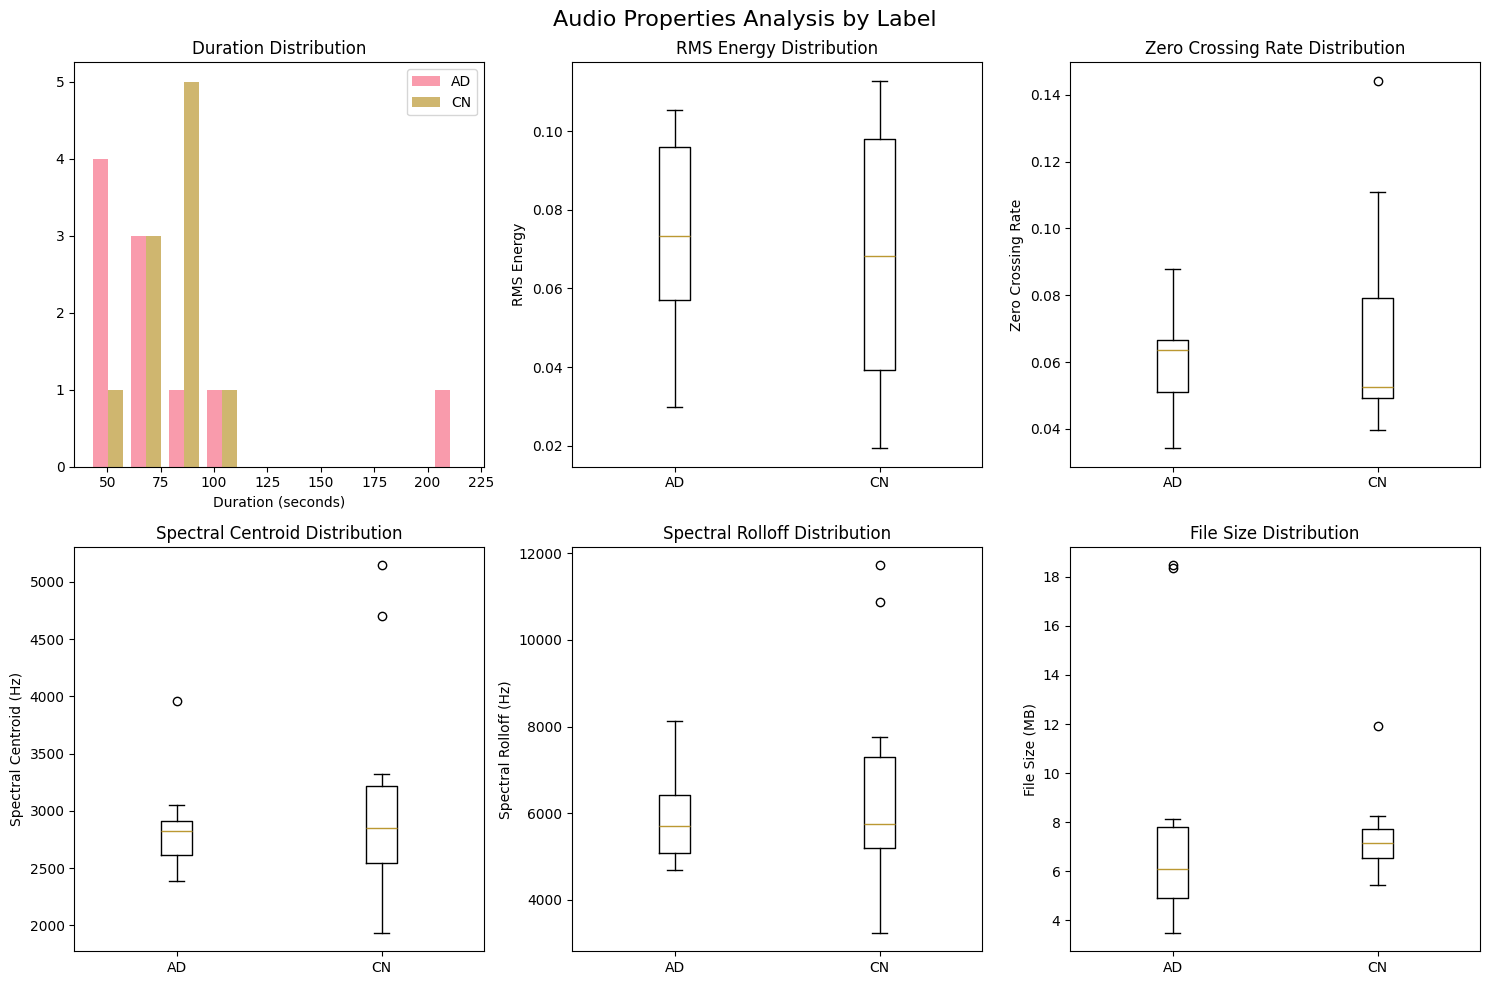


=== SEGMENTATION FILES ANALYSIS ===

Error processing adrso229.csv: unsupported operand type(s) for -: 'str' and 'str'
Error processing adrso106.csv: unsupported operand type(s) for -: 'str' and 'str'
Error processing adrso144.csv: unsupported operand type(s) for -: 'str' and 'str'
Error processing adrso049.csv: unsupported operand type(s) for -: 'str' and 'str'
Error processing adrso078.csv: unsupported operand type(s) for -: 'str' and 'str'
Error processing adrso281.csv: unsupported operand type(s) for -: 'str' and 'str'
Error processing adrso270.csv: unsupported operand type(s) for -: 'str' and 'str'
Error processing adrso308.csv: unsupported operand type(s) for -: 'str' and 'str'
Error processing adrso022.csv: unsupported operand type(s) for -: 'str' and 'str'
Error processing adrso298.csv: unsupported operand type(s) for -: 'str' and 'str'

=== STATISTICAL ANALYSIS ===

Statistical Tests (AD vs CN):
------------------------------------------------------------
duration:
  T-test: 

In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

class ADReSSoEDA:
    def __init__(self, base_path):
        self.base_path = base_path
        self.diagnosis_path = os.path.join(base_path, 'diagnosis')
        self.progression_path = os.path.join(base_path, 'progression')
        self.dataset_info = {}
        self.audio_features = {}

    def scan_dataset_structure(self):
        """Scan and analyze the dataset structure"""
        print("=== DATASET STRUCTURE ANALYSIS ===\n")

        structure = {}

        # Scan diagnosis folder
        if os.path.exists(self.diagnosis_path):
            structure['diagnosis'] = {}
            for subset in ['train', 'test-dist']:
                subset_path = os.path.join(self.diagnosis_path, subset)
                if os.path.exists(subset_path):
                    structure['diagnosis'][subset] = {}

                    # Count audio files
                    audio_path = os.path.join(subset_path, 'audio')
                    if os.path.exists(audio_path):
                        structure['diagnosis'][subset]['audio'] = {}
                        for label in ['ad', 'cn']:
                            label_path = os.path.join(audio_path, label)
                            if os.path.exists(label_path):
                                files = [f for f in os.listdir(label_path) if f.endswith('.wav')]
                                structure['diagnosis'][subset]['audio'][label] = len(files)

                    # Count segmentation files
                    seg_path = os.path.join(subset_path, 'segmentation')
                    if os.path.exists(seg_path):
                        structure['diagnosis'][subset]['segmentation'] = {}
                        for label in ['ad', 'cn']:
                            label_path = os.path.join(seg_path, label)
                            if os.path.exists(label_path):
                                files = [f for f in os.listdir(label_path) if f.endswith('.csv')]
                                structure['diagnosis'][subset]['segmentation'][label] = len(files)

        # Scan progression folder
        if os.path.exists(self.progression_path):
            structure['progression'] = {}
            for subset in ['test-dist']:
                subset_path = os.path.join(self.progression_path, subset)
                if os.path.exists(subset_path):
                    structure['progression'][subset] = {}

                    # Count audio files
                    audio_path = os.path.join(subset_path, 'audio')
                    if os.path.exists(audio_path):
                        files = [f for f in os.listdir(audio_path) if f.endswith('.wav')]
                        structure['progression'][subset]['audio'] = len(files)

                    # Count segmentation files
                    seg_path = os.path.join(subset_path, 'segmentation')
                    if os.path.exists(seg_path):
                        files = [f for f in os.listdir(seg_path) if f.endswith('.csv')]
                        structure['progression'][subset]['segmentation'] = len(files)

        self.dataset_info = structure
        self.print_structure()
        return structure

    def print_structure(self):
        """Print dataset structure in a readable format"""
        print("Dataset Structure:")
        for task, task_data in self.dataset_info.items():
            print(f"\n{task.upper()} TASK:")
            for subset, subset_data in task_data.items():
                print(f"  {subset}:")
                if 'audio' in subset_data:
                    if isinstance(subset_data['audio'], dict):
                        for label, count in subset_data['audio'].items():
                            print(f"    Audio files ({label}): {count}")
                    else:
                        print(f"    Audio files: {subset_data['audio']}")
                if 'segmentation' in subset_data:
                    if isinstance(subset_data['segmentation'], dict):
                        for label, count in subset_data['segmentation'].items():
                            print(f"    Segmentation files ({label}): {count}")
                    else:
                        print(f"    Segmentation files: {subset_data['segmentation']}")

    def analyze_audio_properties(self, sample_size=10):
        """Analyze basic audio properties"""
        print("\n=== AUDIO PROPERTIES ANALYSIS ===\n")

        audio_stats = []

        # Analyze diagnosis training data
        for label in ['ad', 'cn']:
            audio_dir = os.path.join(self.diagnosis_path, 'train', 'audio', label)
            if os.path.exists(audio_dir):
                wav_files = [f for f in os.listdir(audio_dir) if f.endswith('.wav')]

                # Sample files for analysis
                sample_files = wav_files[:sample_size] if len(wav_files) > sample_size else wav_files

                for file in sample_files:
                    filepath = os.path.join(audio_dir, file)
                    try:
                        # Load audio file
                        y, sr = librosa.load(filepath, sr=None)

                        # Calculate basic properties
                        duration = len(y) / sr
                        rms_energy = np.sqrt(np.mean(y**2))
                        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y))

                        # Calculate spectral features
                        spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
                        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)

                        audio_stats.append({
                            'file': file,
                            'label': label,
                            'duration': duration,
                            'sample_rate': sr,
                            'rms_energy': rms_energy,
                            'zero_crossing_rate': zero_crossing_rate,
                            'spectral_centroid_mean': np.mean(spectral_centroids),
                            'spectral_rolloff_mean': np.mean(spectral_rolloff),
                            'file_size_mb': os.path.getsize(filepath) / (1024*1024)
                        })

                    except Exception as e:
                        print(f"Error processing {file}: {e}")

        self.audio_features = pd.DataFrame(audio_stats)

        if not self.audio_features.empty:
            # Print summary statistics
            print("Audio Properties Summary:")
            print(self.audio_features.groupby('label').agg({
                'duration': ['mean', 'std', 'min', 'max'],
                'sample_rate': ['mean', 'std'],
                'rms_energy': ['mean', 'std'],
                'zero_crossing_rate': ['mean', 'std'],
                'spectral_centroid_mean': ['mean', 'std'],
                'file_size_mb': ['mean', 'std']
            }).round(4))

            # Create visualizations
            self.plot_audio_properties()

        return self.audio_features

    def plot_audio_properties(self):
        """Create visualizations for audio properties"""
        if self.audio_features.empty:
            return

        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Audio Properties Analysis by Label', fontsize=16)

        # Duration distribution
        axes[0, 0].hist([self.audio_features[self.audio_features['label'] == 'ad']['duration'],
                        self.audio_features[self.audio_features['label'] == 'cn']['duration']],
                       bins=10, alpha=0.7, label=['AD', 'CN'])
        axes[0, 0].set_title('Duration Distribution')
        axes[0, 0].set_xlabel('Duration (seconds)')
        axes[0, 0].legend()

        # RMS Energy
        axes[0, 1].boxplot([self.audio_features[self.audio_features['label'] == 'ad']['rms_energy'],
                           self.audio_features[self.audio_features['label'] == 'cn']['rms_energy']],
                          labels=['AD', 'CN'])
        axes[0, 1].set_title('RMS Energy Distribution')
        axes[0, 1].set_ylabel('RMS Energy')

        # Zero Crossing Rate
        axes[0, 2].boxplot([self.audio_features[self.audio_features['label'] == 'ad']['zero_crossing_rate'],
                           self.audio_features[self.audio_features['label'] == 'cn']['zero_crossing_rate']],
                          labels=['AD', 'CN'])
        axes[0, 2].set_title('Zero Crossing Rate Distribution')
        axes[0, 2].set_ylabel('Zero Crossing Rate')

        # Spectral Centroid
        axes[1, 0].boxplot([self.audio_features[self.audio_features['label'] == 'ad']['spectral_centroid_mean'],
                           self.audio_features[self.audio_features['label'] == 'cn']['spectral_centroid_mean']],
                          labels=['AD', 'CN'])
        axes[1, 0].set_title('Spectral Centroid Distribution')
        axes[1, 0].set_ylabel('Spectral Centroid (Hz)')

        # Spectral Rolloff
        axes[1, 1].boxplot([self.audio_features[self.audio_features['label'] == 'ad']['spectral_rolloff_mean'],
                           self.audio_features[self.audio_features['label'] == 'cn']['spectral_rolloff_mean']],
                          labels=['AD', 'CN'])
        axes[1, 1].set_title('Spectral Rolloff Distribution')
        axes[1, 1].set_ylabel('Spectral Rolloff (Hz)')

        # File Size
        axes[1, 2].boxplot([self.audio_features[self.audio_features['label'] == 'ad']['file_size_mb'],
                           self.audio_features[self.audio_features['label'] == 'cn']['file_size_mb']],
                          labels=['AD', 'CN'])
        axes[1, 2].set_title('File Size Distribution')
        axes[1, 2].set_ylabel('File Size (MB)')

        plt.tight_layout()
        plt.show()

    def analyze_segmentation_files(self, sample_size=5):
        """Analyze segmentation CSV files"""
        print("\n=== SEGMENTATION FILES ANALYSIS ===\n")

        segmentation_stats = []

        for label in ['ad', 'cn']:
            seg_dir = os.path.join(self.diagnosis_path, 'train', 'segmentation', label)
            if os.path.exists(seg_dir):
                csv_files = [f for f in os.listdir(seg_dir) if f.endswith('.csv')]

                # Sample files for analysis
                sample_files = csv_files[:sample_size] if len(csv_files) > sample_size else csv_files

                for file in sample_files:
                    filepath = os.path.join(seg_dir, file)
                    try:
                        df = pd.read_csv(filepath)

                        # Basic stats about segmentation
                        segmentation_stats.append({
                            'file': file,
                            'label': label,
                            'num_segments': len(df),
                            'columns': list(df.columns),
                            'total_duration': df.iloc[:, 1].max() if len(df.columns) > 1 else 0,
                            'avg_segment_length': df.iloc[:, 1].diff().mean() if len(df.columns) > 1 else 0
                        })

                        # Print first few rows of first file as example
                        if file == sample_files[0]:
                            print(f"Sample segmentation file ({label}): {file}")
                            print(df.head())
                            print(f"Shape: {df.shape}")
                            print(f"Columns: {df.columns.tolist()}")
                            print("-" * 50)

                    except Exception as e:
                        print(f"Error processing {file}: {e}")

        if segmentation_stats:
            seg_df = pd.DataFrame(segmentation_stats)

            print("Segmentation Statistics:")
            print(seg_df.groupby('label').agg({
                'num_segments': ['mean', 'std', 'min', 'max'],
                'total_duration': ['mean', 'std'],
                'avg_segment_length': ['mean', 'std']
            }).round(4))

            # Plot segmentation statistics
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))

            # Number of segments
            axes[0].boxplot([seg_df[seg_df['label'] == 'ad']['num_segments'],
                            seg_df[seg_df['label'] == 'cn']['num_segments']],
                           labels=['AD', 'CN'])
            axes[0].set_title('Number of Segments per File')
            axes[0].set_ylabel('Number of Segments')

            # Average segment length
            axes[1].boxplot([seg_df[seg_df['label'] == 'ad']['avg_segment_length'],
                            seg_df[seg_df['label'] == 'cn']['avg_segment_length']],
                           labels=['AD', 'CN'])
            axes[1].set_title('Average Segment Length')
            axes[1].set_ylabel('Average Length (seconds)')

            plt.tight_layout()
            plt.show()

        return segmentation_stats

    def statistical_analysis(self):
        """Perform statistical analysis between AD and CN groups"""
        if self.audio_features.empty:
            return

        print("\n=== STATISTICAL ANALYSIS ===\n")

        ad_data = self.audio_features[self.audio_features['label'] == 'ad']
        cn_data = self.audio_features[self.audio_features['label'] == 'cn']

        features_to_test = ['duration', 'rms_energy', 'zero_crossing_rate',
                          'spectral_centroid_mean', 'spectral_rolloff_mean']

        print("Statistical Tests (AD vs CN):")
        print("-" * 60)

        for feature in features_to_test:
            if feature in ad_data.columns and feature in cn_data.columns:
                # T-test
                t_stat, p_value = stats.ttest_ind(ad_data[feature], cn_data[feature])

                # Mann-Whitney U test (non-parametric)
                u_stat, u_p_value = stats.mannwhitneyu(ad_data[feature], cn_data[feature])

                print(f"{feature}:")
                print(f"  T-test: t={t_stat:.4f}, p={p_value:.4f}")
                print(f"  Mann-Whitney U: U={u_stat:.4f}, p={u_p_value:.4f}")
                print(f"  AD mean: {ad_data[feature].mean():.4f} ± {ad_data[feature].std():.4f}")
                print(f"  CN mean: {cn_data[feature].mean():.4f} ± {cn_data[feature].std():.4f}")
                print()

    def run_complete_eda(self):
        """Run complete EDA analysis"""
        print("Starting Complete EDA for ADReSSo21 Dataset")
        print("=" * 50)

        # 1. Dataset structure analysis
        self.scan_dataset_structure()

        # 2. Audio properties analysis
        self.analyze_audio_properties()

        # 3. Segmentation analysis
        self.analyze_segmentation_files()

        # 4. Statistical analysis
        self.statistical_analysis()

        print("\n=== EDA COMPLETE ===")
        print("Summary of findings:")
        print(f"- Total diagnosis training files analyzed: {len(self.audio_features)}")
        print(f"- Labels: {self.audio_features['label'].value_counts().to_dict() if not self.audio_features.empty else 'None'}")

        return self.audio_features

# Usage example:
if __name__ == "__main__":
    # Initialize EDA
    dataset_path = "/content/drive/MyDrive/Voice/extracted/ADReSSo21"
    eda = ADReSSoEDA(dataset_path)

    # Run complete analysis
    results = eda.run_complete_eda()

    # Optional: Save results
    if not results.empty:
        results.to_csv("adresso_audio_features.csv", index=False)
        print(f"\nResults saved to: adresso_audio_features.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Setup complete! Libraries installed and paths configured.
Loading dataset...
Loaded 87 AD files, 79 CN files, 32 test files
Total files: 198

Dataset Overview:
       sample_rate    duration   num_samples
count        198.0  198.000000  1.980000e+02
mean       44100.0   89.020188  3.925790e+06
std            0.0   44.389815  1.957591e+06
min        44100.0   22.785261  1.004830e+06
25%        44100.0   56.959433  2.511911e+06
50%        44100.0   77.135544  3.401678e+06
75%        44100.0  114.715765  5.058965e+06
max        44100.0  268.486531  1.184026e+07
Performing time-domain analysis...


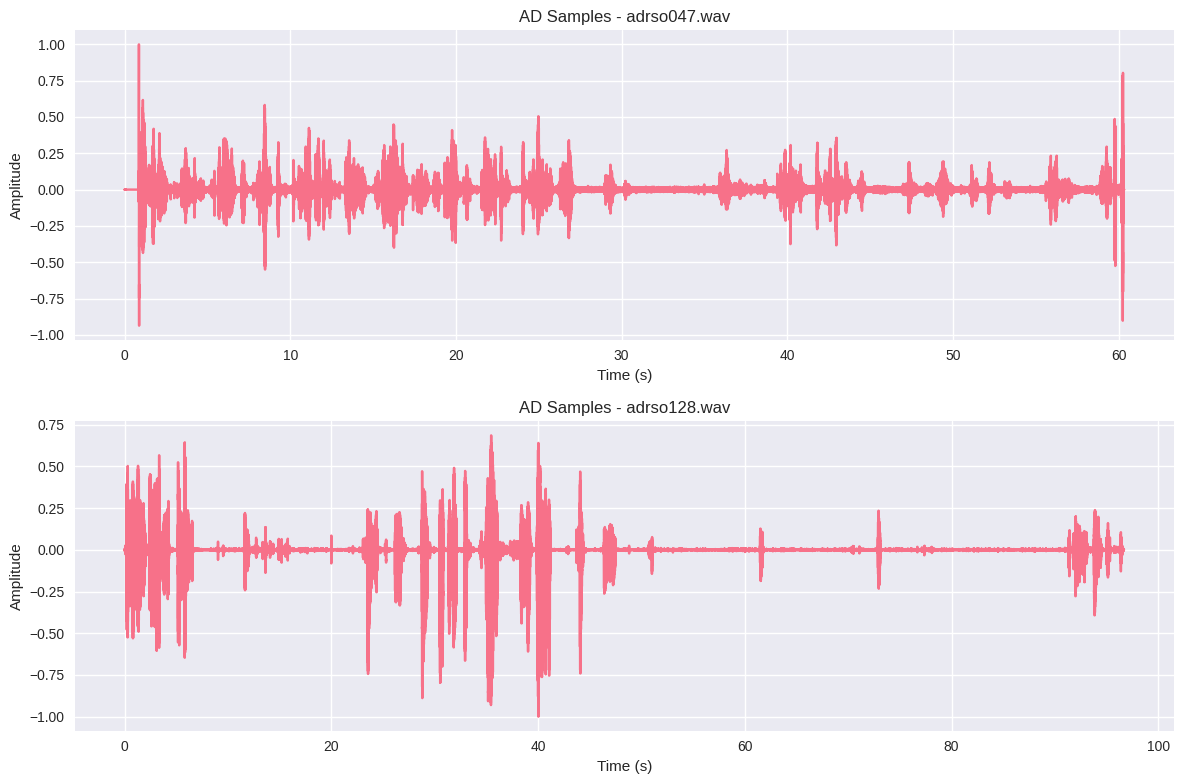

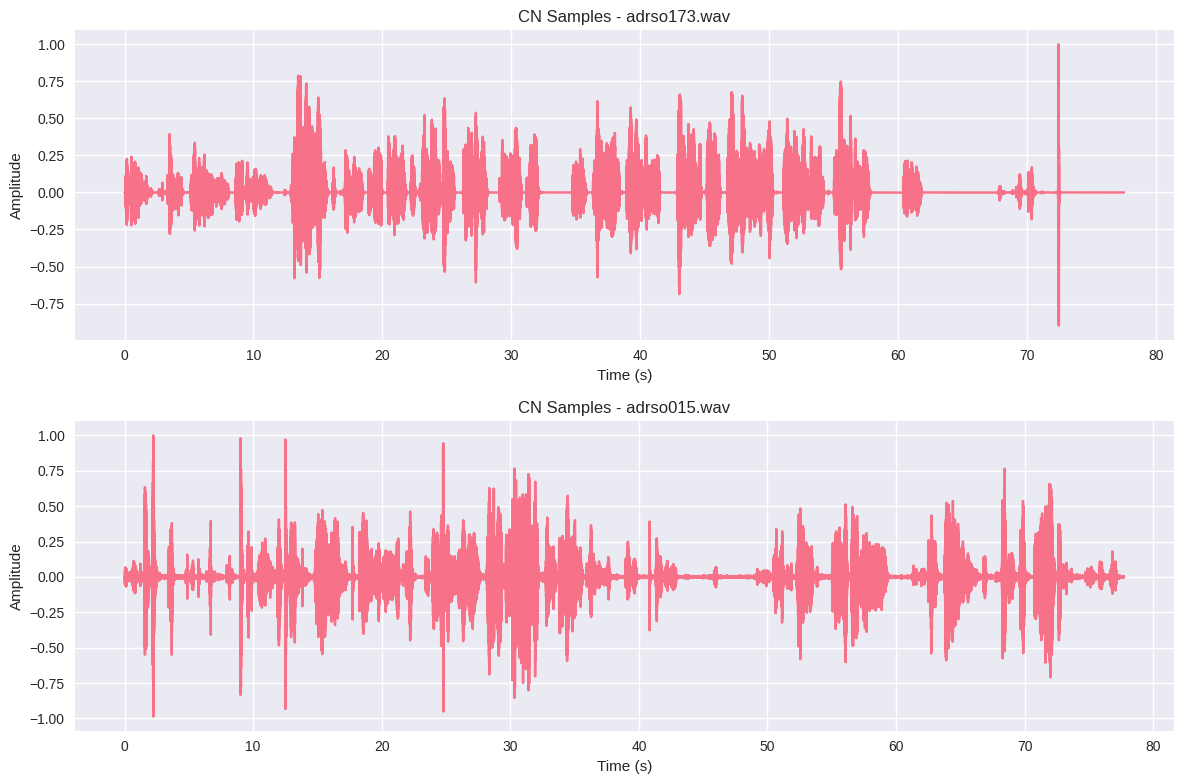


Amplitude Statistics:
      mean_amp                                                              \
         count      mean       std       min       25%       50%       75%   
label                                                                        
ad        87.0  0.025770  0.019399  0.003262  0.012885  0.022090  0.033035   
cn        79.0  0.034993  0.030636  0.004738  0.013070  0.028260  0.044795   
test      32.0  0.014117  0.011008  0.001795  0.008843  0.010504  0.013266   

                median_amp            ...   max_amp             rms            \
            max      count      mean  ...       75%       max count      mean   
label                                 ...                                       
ad     0.119391       87.0  0.004239  ...  0.999969  1.018751  87.0  0.059942   
cn     0.155745       79.0  0.008456  ...  0.999969  1.819208  79.0  0.073331   
test   0.055864       32.0  0.001440  ...  0.927078  1.017102  32.0  0.042639   

                     

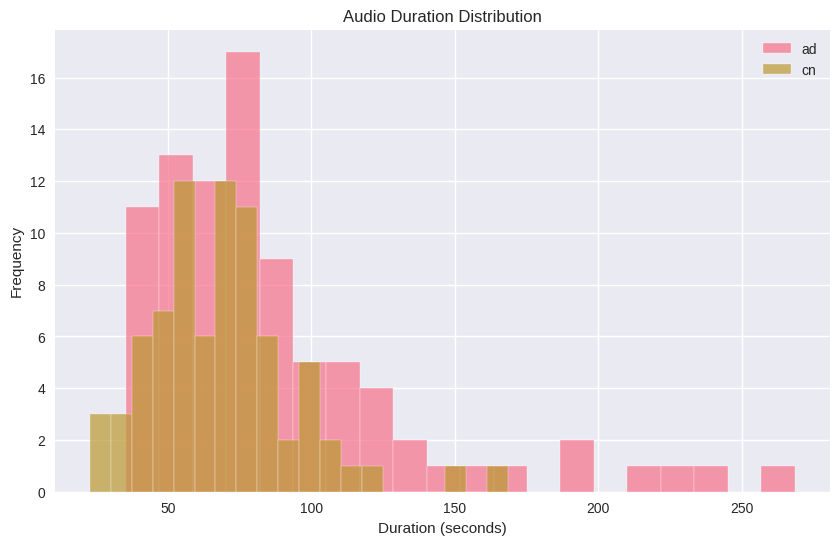


Silence Detection Results:
      silence_ratio                                                   \
              count      mean           std  min       25%       50%   
label                                                                  
ad             87.0  0.185782  2.623039e-02  0.0  0.181229  0.195982   
cn             79.0  0.182392  3.496076e-02  0.0  0.183039  0.196424   
test           32.0  0.200000  5.689965e-08  0.2  0.200000  0.200000   

                     threshold                                          \
            75%  max     count      mean       std       min       25%   
label                                                                    
ad     0.199438  0.2      87.0  0.000790  0.001112  0.000000  0.000137   
cn     0.199296  0.2      79.0  0.001203  0.001632  0.000000  0.000183   
test   0.200000  0.2      32.0  0.000492  0.000253  0.000158  0.000295   

                                     
            50%       75%       max  
label             

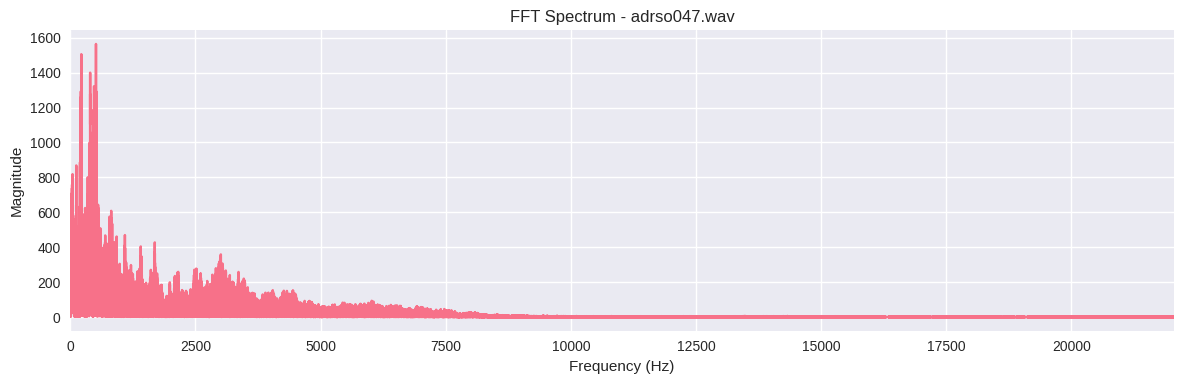

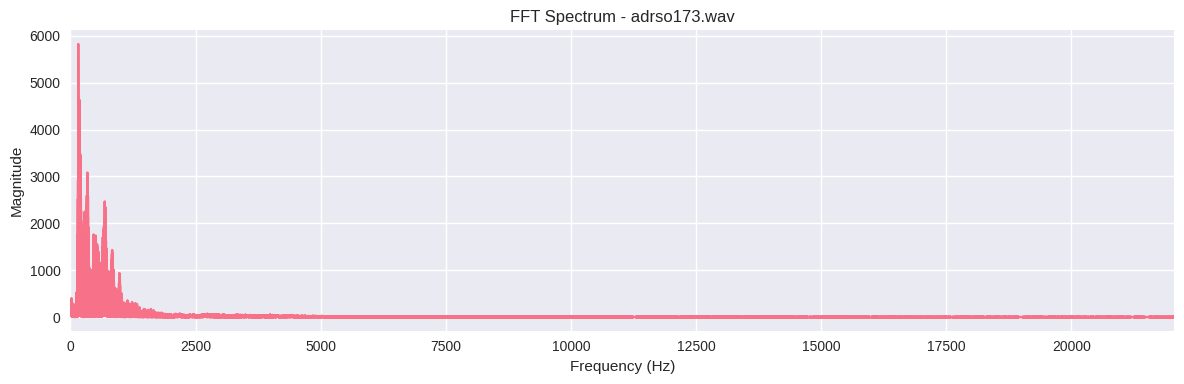


Spectral Features:
      spectral_centroid_mean                                        \
                       count         mean         std          min   
label                                                                
ad                      87.0  3116.474925  929.535563   929.267704   
cn                      79.0  3127.916676  921.092234  1799.468640   
test                    32.0  2642.960751  825.937013  1312.231883   

                                                           \
               25%          50%          75%          max   
label                                                       
ad     2524.282091  2938.678943  3742.915112  5378.281834   
cn     2496.582175  2919.695882  3442.058056  5624.673360   
test   2009.919038  2511.326888  3419.951200  4162.480351   

      spectral_centroid_std               ... spectral_bandwidth_mean  \
                      count         mean  ...                     75%   
label                                     ... 

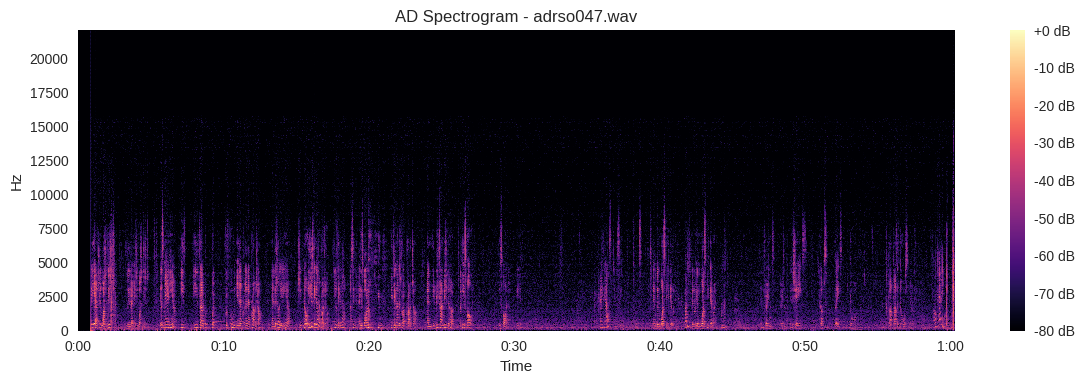

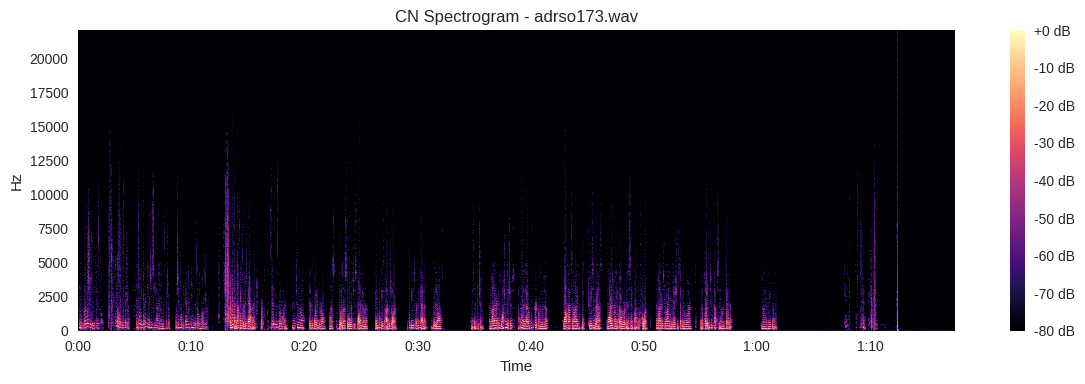

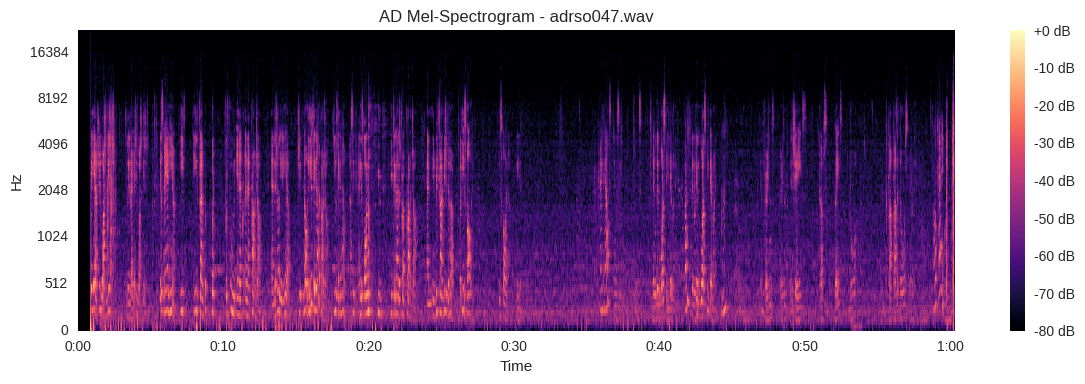

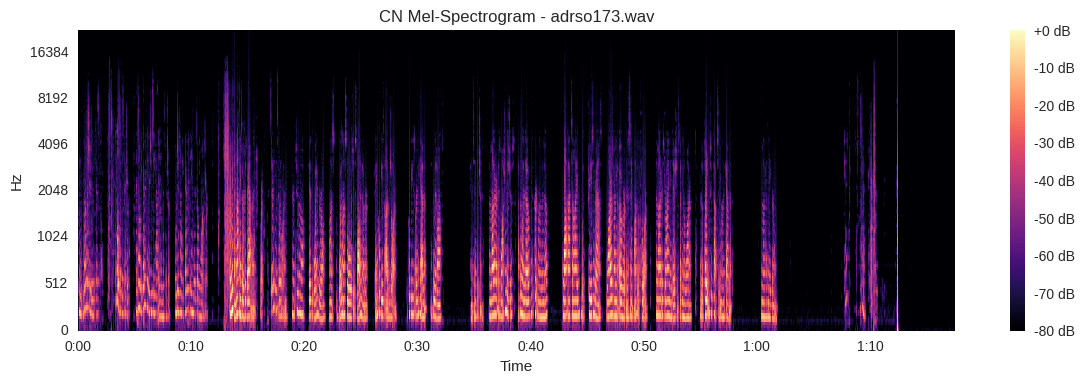

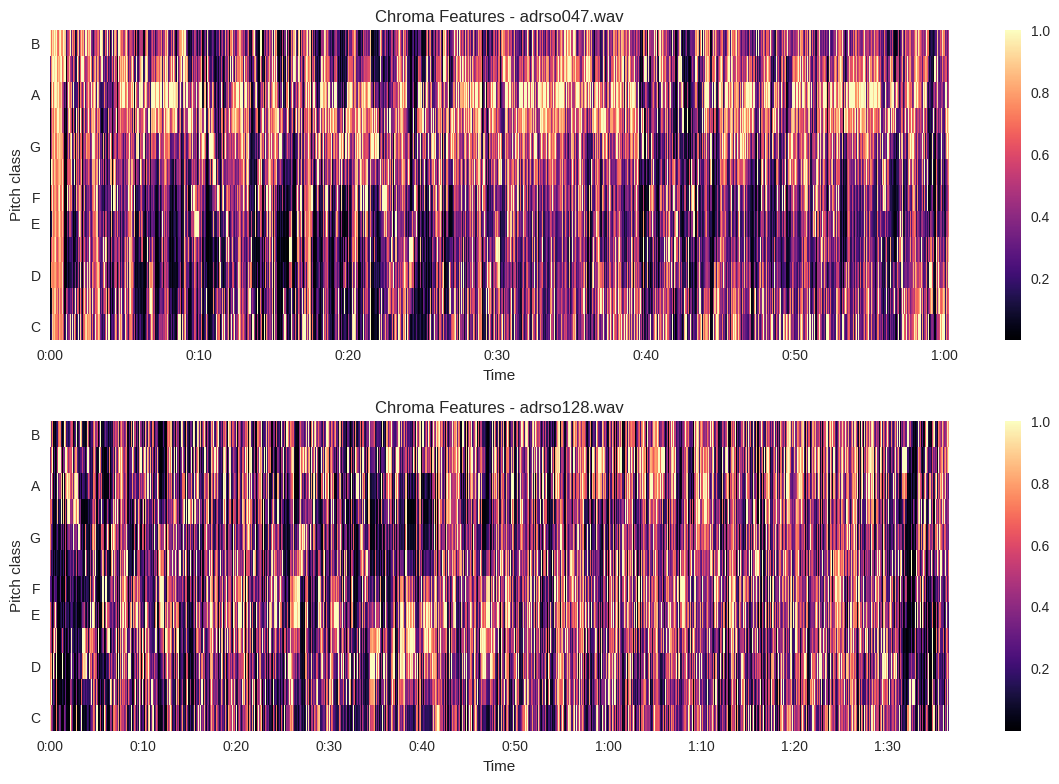

Extracting statistical and feature-based analysis...

MFCC Features extracted


In [ ]:
# ADReSSo21 Audio Data Analysis Workflow for Google Colab
# Alzheimer's Dementia Recognition through Speech (ADReSSo21 Dataset)

# ================================
# 1. INITIAL SETUP
# ================================

# Install required libraries
!pip install librosa soundfile scikit-learn imbalanced-learn

# Import libraries
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import soundfile as sf
from scipy import signal, stats
from scipy.fft import fft, fftfreq
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define dataset paths
BASE_PATH = '/content/drive/MyDrive/Voice/extracted/ADReSSo21'
AUDIO_PATHS = {
    'train_ad': f'{BASE_PATH}/diagnosis/train/audio/ad/*.wav',
    'train_cn': f'{BASE_PATH}/diagnosis/train/audio/cn/*.wav',
    'test': f'{BASE_PATH}/progression/test-dist/audio/*.wav'
}

SEGMENTATION_PATHS = {
    'train_ad': f'{BASE_PATH}/diagnosis/train/segmentation/ad/*.csv',
    'train_cn': f'{BASE_PATH}/diagnosis/train/segmentation/cn/*.csv',
    'test': f'{BASE_PATH}/progression/test-dist/segmentation/*.csv'
}

# Create output directories
os.makedirs('/content/output/visualizations', exist_ok=True)
os.makedirs('/content/output/preprocessed', exist_ok=True)
os.makedirs('/content/output/features', exist_ok=True)

print("Setup complete! Libraries installed and paths configured.")

# ================================
# UTILITY FUNCTIONS
# ================================

def load_audio_files(pattern, label=None):
    """Load audio files matching a pattern."""
    files = glob.glob(pattern)
    audio_data = []

    for file_path in files:
        try:
            y, sr = librosa.load(file_path, sr=None)
            audio_data.append({
                'file_path': file_path,
                'filename': os.path.basename(file_path),
                'audio': y,
                'sample_rate': sr,
                'label': label,
                'duration': len(y) / sr
            })
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    return audio_data

def load_segmentation_files(pattern):
    """Load segmentation CSV files."""
    files = glob.glob(pattern)
    segmentation_data = {}

    for file_path in files:
        try:
            df = pd.read_csv(file_path)
            filename = os.path.basename(file_path).replace('.csv', '.wav')
            segmentation_data[filename] = df
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    return segmentation_data

def create_metadata_dataframe(audio_data):
    """Create metadata DataFrame from audio data."""
    metadata = []
    for item in audio_data:
        metadata.append({
            'filename': item['filename'],
            'file_path': item['file_path'],
            'label': item['label'],
            'sample_rate': item['sample_rate'],
            'duration': item['duration'],
            'num_samples': len(item['audio'])
        })

    return pd.DataFrame(metadata)

# ================================
# 2. INITIAL EDA
# ================================

print("Loading dataset...")

# Load audio files
train_ad_data = load_audio_files(AUDIO_PATHS['train_ad'], 'ad')
train_cn_data = load_audio_files(AUDIO_PATHS['train_cn'], 'cn')
test_data = load_audio_files(AUDIO_PATHS['test'], 'test')

# Load segmentation files
train_ad_seg = load_segmentation_files(SEGMENTATION_PATHS['train_ad'])
train_cn_seg = load_segmentation_files(SEGMENTATION_PATHS['train_cn'])
test_seg = load_segmentation_files(SEGMENTATION_PATHS['test'])

# Combine all data
all_audio_data = train_ad_data + train_cn_data + test_data

# Create metadata DataFrame
metadata_df = create_metadata_dataframe(all_audio_data)

print(f"Loaded {len(train_ad_data)} AD files, {len(train_cn_data)} CN files, {len(test_data)} test files")
print(f"Total files: {len(all_audio_data)}")

# Display basic statistics
print("\nDataset Overview:")
print(metadata_df.describe())

# ================================
# TIME-DOMAIN ANALYSIS
# ================================

def plot_waveforms(audio_data, title_prefix="", max_plots=3):
    """Plot waveforms for sample audio files."""
    fig, axes = plt.subplots(min(len(audio_data), max_plots), 1, figsize=(12, 4*min(len(audio_data), max_plots)))
    if min(len(audio_data), max_plots) == 1:
        axes = [axes]

    for i, item in enumerate(audio_data[:max_plots]):
        time = np.linspace(0, item['duration'], len(item['audio']))
        axes[i].plot(time, item['audio'])
        axes[i].set_title(f"{title_prefix} - {item['filename']}")
        axes[i].set_xlabel('Time (s)')
        axes[i].set_ylabel('Amplitude')
        axes[i].grid(True)

    plt.tight_layout()
    plt.savefig(f'/content/output/visualizations/waveforms_{title_prefix.lower().replace(" ", "_")}.png', dpi=150)
    plt.show()

def compute_amplitude_statistics(audio_data):
    """Compute amplitude statistics for audio files."""
    stats_data = []

    for item in audio_data:
        y = item['audio']
        stats_data.append({
            'filename': item['filename'],
            'label': item['label'],
            'mean_amp': np.mean(np.abs(y)),
            'median_amp': np.median(np.abs(y)),
            'std_amp': np.std(y),
            'min_amp': np.min(y),
            'max_amp': np.max(y),
            'rms': np.sqrt(np.mean(y**2))
        })

    return pd.DataFrame(stats_data)

def compute_zero_crossing_rate(audio_data):
    """Compute zero-crossing rate for audio files."""
    zcr_data = []

    for item in audio_data:
        zcr = librosa.feature.zero_crossing_rate(item['audio'])[0]
        zcr_data.append({
            'filename': item['filename'],
            'label': item['label'],
            'zcr_mean': np.mean(zcr),
            'zcr_std': np.std(zcr),
            'zcr_median': np.median(zcr)
        })

    return pd.DataFrame(zcr_data)

def detect_silence(audio_data, threshold_percentile=20):
    """Detect silence periods in audio files."""
    silence_data = []

    for item in audio_data:
        y = item['audio']
        threshold = np.percentile(np.abs(y), threshold_percentile)
        silence_mask = np.abs(y) < threshold
        silence_ratio = np.sum(silence_mask) / len(y)

        silence_data.append({
            'filename': item['filename'],
            'label': item['label'],
            'silence_ratio': silence_ratio,
            'threshold': threshold
        })

    return pd.DataFrame(silence_data)

print("Performing time-domain analysis...")

# Plot sample waveforms
plot_waveforms(train_ad_data, "AD Samples", max_plots=2)
plot_waveforms(train_cn_data, "CN Samples", max_plots=2)

# Compute amplitude statistics
amp_stats = compute_amplitude_statistics(all_audio_data)
print("\nAmplitude Statistics:")
print(amp_stats.groupby('label').describe())

# Compute zero-crossing rate
zcr_stats = compute_zero_crossing_rate(all_audio_data)
print("\nZero-Crossing Rate Statistics:")
print(zcr_stats.groupby('label').describe())

# Plot duration histogram
plt.figure(figsize=(10, 6))
for label in ['ad', 'cn']:
    durations = metadata_df[metadata_df['label'] == label]['duration']
    plt.hist(durations, alpha=0.7, label=label, bins=20)
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Audio Duration Distribution')
plt.legend()
plt.grid(True)
plt.savefig('/content/output/visualizations/duration_histogram.png', dpi=150)
plt.show()

# Detect silence
silence_stats = detect_silence(all_audio_data)
print("\nSilence Detection Results:")
print(silence_stats.groupby('label').describe())

# ================================
# FREQUENCY-DOMAIN ANALYSIS
# ================================

def compute_fft_spectrum(audio_data, max_plots=2):
    """Compute and plot FFT spectrum for sample audio files."""
    fig, axes = plt.subplots(min(len(audio_data), max_plots), 1, figsize=(12, 4*min(len(audio_data), max_plots)))
    if min(len(audio_data), max_plots) == 1:
        axes = [axes]

    for i, item in enumerate(audio_data[:max_plots]):
        y = item['audio']
        sr = item['sample_rate']

        # Compute FFT
        n = len(y)
        yf = fft(y)
        xf = fftfreq(n, 1/sr)

        # Plot only positive frequencies
        pos_mask = xf >= 0
        axes[i].plot(xf[pos_mask], np.abs(yf[pos_mask]))
        axes[i].set_title(f"FFT Spectrum - {item['filename']}")
        axes[i].set_xlabel('Frequency (Hz)')
        axes[i].set_ylabel('Magnitude')
        axes[i].set_xlim(0, sr/2)
        axes[i].grid(True)

    plt.tight_layout()
    plt.savefig('/content/output/visualizations/fft_spectrum.png', dpi=150)
    plt.show()

def compute_spectral_features(audio_data):
    """Compute spectral features for audio files."""
    spectral_data = []

    for item in audio_data:
        y = item['audio']
        sr = item['sample_rate']

        # Compute spectral features
        spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]

        spectral_data.append({
            'filename': item['filename'],
            'label': item['label'],
            'spectral_centroid_mean': np.mean(spectral_centroids),
            'spectral_centroid_std': np.std(spectral_centroids),
            'spectral_rolloff_mean': np.mean(spectral_rolloff),
            'spectral_rolloff_std': np.std(spectral_rolloff),
            'spectral_bandwidth_mean': np.mean(spectral_bandwidth),
            'spectral_bandwidth_std': np.std(spectral_bandwidth)
        })

    return pd.DataFrame(spectral_data)

print("Performing frequency-domain analysis...")

# Compute FFT spectrum for samples
compute_fft_spectrum(train_ad_data, max_plots=1)
compute_fft_spectrum(train_cn_data, max_plots=1)

# Compute spectral features
spectral_features = compute_spectral_features(all_audio_data)
print("\nSpectral Features:")
print(spectral_features.groupby('label').describe())

# ================================
# TIME-FREQUENCY ANALYSIS
# ================================

def plot_spectrograms(audio_data, title_prefix="", max_plots=2):
    """Generate and plot spectrograms for sample audio files."""
    fig, axes = plt.subplots(min(len(audio_data), max_plots), 1, figsize=(12, 4*min(len(audio_data), max_plots)))
    if min(len(audio_data), max_plots) == 1:
        axes = [axes]

    for i, item in enumerate(audio_data[:max_plots]):
        y = item['audio']
        sr = item['sample_rate']

        # Compute spectrogram
        D = librosa.stft(y)
        S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

        img = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', ax=axes[i])
        axes[i].set_title(f"{title_prefix} Spectrogram - {item['filename']}")
        fig.colorbar(img, ax=axes[i], format='%+2.0f dB')

    plt.tight_layout()
    plt.savefig(f'/content/output/visualizations/spectrograms_{title_prefix.lower().replace(" ", "_")}.png', dpi=150)
    plt.show()

def plot_mel_spectrograms(audio_data, title_prefix="", max_plots=2):
    """Generate and plot Mel-spectrograms for sample audio files."""
    fig, axes = plt.subplots(min(len(audio_data), max_plots), 1, figsize=(12, 4*min(len(audio_data), max_plots)))
    if min(len(audio_data), max_plots) == 1:
        axes = [axes]

    for i, item in enumerate(audio_data[:max_plots]):
        y = item['audio']
        sr = item['sample_rate']

        # Compute Mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        img = librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', ax=axes[i])
        axes[i].set_title(f"{title_prefix} Mel-Spectrogram - {item['filename']}")
        fig.colorbar(img, ax=axes[i], format='%+2.0f dB')

    plt.tight_layout()
    plt.savefig(f'/content/output/visualizations/mel_spectrograms_{title_prefix.lower().replace(" ", "_")}.png', dpi=150)
    plt.show()

def extract_chroma_features(audio_data, max_plots=2):
    """Extract and plot chroma features for sample audio files."""
    fig, axes = plt.subplots(min(len(audio_data), max_plots), 1, figsize=(12, 4*min(len(audio_data), max_plots)))
    if min(len(audio_data), max_plots) == 1:
        axes = [axes]

    chroma_data = []

    for i, item in enumerate(audio_data[:max_plots]):
        y = item['audio']
        sr = item['sample_rate']

        # Compute chroma features
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)

        # Plot chroma features
        img = librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', ax=axes[i])
        axes[i].set_title(f"Chroma Features - {item['filename']}")
        fig.colorbar(img, ax=axes[i])

        # Store chroma statistics
        chroma_data.append({
            'filename': item['filename'],
            'label': item['label'],
            'chroma_mean': np.mean(chroma),
            'chroma_std': np.std(chroma)
        })

    plt.tight_layout()
    plt.savefig('/content/output/visualizations/chroma_features.png', dpi=150)
    plt.show()

    return pd.DataFrame(chroma_data)

print("Performing time-frequency analysis...")

# Generate spectrograms
plot_spectrograms(train_ad_data, "AD", max_plots=1)
plot_spectrograms(train_cn_data, "CN", max_plots=1)

# Generate Mel-spectrograms
plot_mel_spectrograms(train_ad_data, "AD", max_plots=1)
plot_mel_spectrograms(train_cn_data, "CN", max_plots=1)

# Extract chroma features
chroma_features = extract_chroma_features(train_ad_data + train_cn_data, max_plots=2)

# ================================
# STATISTICAL AND FEATURE-BASED ANALYSIS
# ================================

def extract_mfcc_features(audio_data, n_mfcc=13):
    """Extract MFCC features for audio files."""
    mfcc_data = []

    for item in audio_data:
        y = item['audio']
        sr = item['sample_rate']

        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

        # Compute statistics for each MFCC coefficient
        mfcc_stats = {}
        for i in range(n_mfcc):
            mfcc_stats[f'mfcc_{i}_mean'] = np.mean(mfccs[i])
            mfcc_stats[f'mfcc_{i}_std'] = np.std(mfccs[i])

        mfcc_stats['filename'] = item['filename']
        mfcc_stats['label'] = item['label']
        mfcc_data.append(mfcc_stats)

    return pd.DataFrame(mfcc_data)

def extract_delta_features(audio_data, n_mfcc=13):
    """Extract delta and delta-delta features for MFCCs."""
    delta_data = []

    for item in audio_data:
        y = item['audio']
        sr = item['sample_rate']

        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

        # Compute delta and delta-delta
        delta_mfccs = librosa.feature.delta(mfccs)
        delta2_mfccs = librosa.feature.delta(mfccs, order=2)

        # Compute statistics
        delta_stats = {}
        for i in range(n_mfcc):
            delta_stats[f'delta_mfcc_{i}_mean'] = np.mean(delta_mfccs[i])
            delta_stats[f'delta_mfcc_{i}_std'] = np.std(delta_mfccs[i])
            delta_stats[f'delta2_mfcc_{i}_mean'] = np.mean(delta2_mfccs[i])
            delta_stats[f'delta2_mfcc_{i}_std'] = np.std(delta2_mfccs[i])

        delta_stats['filename'] = item['filename']
        delta_stats['label'] = item['label']
        delta_data.append(delta_stats)

    return pd.DataFrame(delta_data)

def compute_energy_features(audio_data):
    """Compute short-term energy and log-energy features."""
    energy_data = []

    for item in audio_data:
        y = item['audio']

        # Compute short-term energy
        frame_length = 2048
        hop_length = 512

        # Frame the signal
        frames = librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length)

        # Compute energy for each frame
        energy = np.sum(frames**2, axis=0)
        log_energy = np.log(energy + 1e-8)  # Add small epsilon to avoid log(0)

        energy_data.append({
            'filename': item['filename'],
            'label': item['label'],
            'energy_mean': np.mean(energy),
            'energy_std': np.std(energy),
            'log_energy_mean': np.mean(log_energy),
            'log_energy_std': np.std(log_energy)
        })

    return pd.DataFrame(energy_data)

print("Extracting statistical and feature-based analysis...")

# Extract MFCC features
mfcc_features = extract_mfcc_features(all_audio_data)
print("\nMFCC Features extracted")

# Extract delta features
delta_features = extract_delta_features(all_audio_data)
print("Delta and Delta-Delta features extracted")

# Compute energy features
energy_features = compute_energy_features(all_audio_data)
print("Energy features extracted")

# Combine all features
all_features = pd.merge(mfcc_features, delta_features, on=['filename', 'label'])
all_features = pd.merge(all_features, energy_features, on=['filename', 'label'])
all_features = pd.merge(all_features, zcr_stats, on=['filename', 'label'])
all_features = pd.merge(all_features, spectral_features, on=['filename', 'label'])
all_features = pd.merge(all_features, amp_stats, on=['filename', 'label'])

print(f"\nCombined features shape: {all_features.shape}")

# Create correlation heatmap
plt.figure(figsize=(20, 16))
# Select only numeric columns for correlation
numeric_cols = all_features.select_dtypes(include=[np.number]).columns
corr_matrix = all_features[numeric_cols].corr()

# Plot heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig('/content/output/visualizations/feature_correlation_heatmap.png', dpi=150)
plt.show()

# ================================
# DATASET-LEVEL ANALYSIS
# ================================

print("Performing dataset-level analysis...")

# Plot class distribution
train_data = all_features[all_features['label'].isin(['ad', 'cn'])]
plt.figure(figsize=(8, 6))
class_counts = train_data['label'].value_counts()
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution (Train Set)')
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 0.1, str(v), ha='center')
plt.savefig('/content/output/visualizations/class_distribution.png', dpi=150)
plt.show()

# Check sample rate consistency
print("\nSample Rate Analysis:")
print(metadata_df['sample_rate'].value_counts())

# Check for corrupted files
print("\nFile Integrity Check:")
print(f"Files with zero duration: {sum(metadata_df['duration'] == 0)}")
print(f"Files with very short duration (<1s): {sum(metadata_df['duration'] < 1)}")
print(f"Files with very long duration (>300s): {sum(metadata_df['duration'] > 300)}")

# ================================
# VISUALIZATION TECHNIQUES
# ================================

def create_comparison_plots():
    """Create comparison plots for AD vs CN."""

    # MFCC comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # MFCC boxplot
    mfcc_cols = [col for col in all_features.columns if 'mfcc_' in col and '_mean' in col][:6]
    mfcc_data = []
    for col in mfcc_cols:
        for label in ['ad', 'cn']:
            values = all_features[all_features['label'] == label][col]
            for val in values:
                mfcc_data.append({'MFCC': col, 'Value': val, 'Label': label})

    mfcc_df = pd.DataFrame(mfcc_data)
    sns.boxplot(data=mfcc_df, x='MFCC', y='Value', hue='Label', ax=axes[0,0])
    axes[0,0].set_title('MFCC Comparison (AD vs CN)')
    axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)

    # ZCR comparison
    zcr_data = []
    for label in ['ad', 'cn']:
        values = all_features[all_features['label'] == label]['zcr_mean']
        for val in values:
            zcr_data.append({'ZCR': val, 'Label': label})

    zcr_df = pd.DataFrame(zcr_data)
    sns.boxplot(data=zcr_df, x='Label', y='ZCR', ax=axes[0,1])
    axes[0,1].set_title('Zero-Crossing Rate Comparison')

    # Spectral centroid comparison
    spec_data = []
    for label in ['ad', 'cn']:
        values = all_features[all_features['label'] == label]['spectral_centroid_mean']
        for val in values:
            spec_data.append({'Spectral_Centroid': val, 'Label': label})

    spec_df = pd.DataFrame(spec_data)
    sns.boxplot(data=spec_df, x='Label', y='Spectral_Centroid', ax=axes[1,0])
    axes[1,0].set_title('Spectral Centroid Comparison')

    # Scatter plot: Spectral centroid vs ZCR
    for label in ['ad', 'cn']:
        data = all_features[all_features['label'] == label]
        axes[1,1].scatter(data['spectral_centroid_mean'], data['zcr_mean'],
                         alpha=0.6, label=label)

    axes[1,1].set_xlabel('Spectral Centroid')
    axes[1,1].set_ylabel('Zero-Crossing Rate')
    axes[1,1].set_title('Spectral Centroid vs ZCR')
    axes[1,1].legend()
    axes[1,1].grid(True)

    plt.tight_layout()
    plt.savefig('/content/output/visualizations/feature_comparison_plots.png', dpi=150)
    plt.show()

create_comparison_plots()

# ================================
# ANOMALY DETECTION
# ================================

def detect_outliers(features_df, z_threshold=3):
    """Detect outliers using z-scores."""
    numeric_cols = features_df.select_dtypes(include=[np.number]).columns
    outlier_info = {}

    for col in numeric_cols:
        z_scores = np.abs(stats.zscore(features_df[col].fillna(0)))
        outliers = features_df[z_scores > z_threshold]
        outlier_info[col] = {
            'count': len(outliers),
            'filenames': outliers['filename'].tolist()
        }

    return outlier_info

def compute_snr(audio_data):
    """Compute signal-to-noise ratio for audio files."""
    snr_data = []

    for item in audio_data:
        y = item['audio']

        # Simple SNR estimation (signal power / noise power)
        # Assume noise is the quietest 10% of the signal
        signal_power = np.mean(y**2)
        noise_threshold = np.percentile(np.abs(y), 10)
        noise_power = np.mean(y[np.abs(y) < noise_threshold]**2)

        if noise_power > 0:
            snr = 10 * np.log10(signal_power / noise_power)
        else:
            snr = np.inf

        snr_data.append({
            'filename': item['filename'],
            'label': item['label'],
            'snr': snr
        })

    return pd.DataFrame(snr_data)

print("Performing anomaly detection...")

# Detect outliers
outlier_info = detect_outliers(all_features)
print(f"\nOutlier detection completed. Found outliers in {len(outlier_info)} features.")

# Compute SNR
snr_data = compute_snr(all_audio_data)
print("\nSNR Statistics:")
print(snr_data.groupby('label')['snr'].describe())

# Plot SNR distribution
plt.figure(figsize=(10, 6))
for label in ['ad', 'cn']:
    snr_values = snr_data[snr_data['label'] == label]['snr']
    # Remove infinite values for plotting
    snr_values = snr_values[snr_values != np.inf]
    plt.hist(snr_values, alpha=0.7, label=label, bins=20)

plt.xlabel('SNR (dB)')
plt.ylabel('Frequency')
plt.title('Signal-to-Noise Ratio Distribution')
plt.legend()
plt.grid(True)
plt.savefig('/content/output/visualizations/snr_distribution.png', dpi=150)
plt.show()